In [1]:
# NOTEBOOK IMPORTS
import os, glob, zipfile
import numpy as np
from tqdm.notebook import tqdm
from shutil import copyfile
from datetime import datetime

# IMAGE IMPORTS
import cv2
from PIL import Image

# GIS IMPORTS
import fiona, pyproj
from affine import Affine
from shapely.geometry import shape, mapping, Point, LineString, MultiPolygon
from shapely.ops import transform, nearest_points, snap
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from scipy.spatial import cKDTree

# PLOTTING IMPORTS
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# CUSTOM UTILITIES
from WorldFileUtils import *
from GeometryUtils import *
from icp import *
from DataUtils import *
from FindGrid import *

Image.MAX_IMAGE_PIXELS = 933120000

C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def getGEOID(CID,):
    # DEALING WITH A COMMUNITY ID (CID)
    if CID >= 9e4:
        output = CIDs[CIDs["CID"] == CID]["GEOID_p"].to_numpy()
    else: # DEALING WITH A COUNTY
        output = np.asarray([CID])
    
    if output.size == 0:
        return None
    return output[0]

def getGeometry(geoid, new_epsg=3857):
    
    project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), pyproj.CRS(f'EPSG:{new_epsg}'), 
                                          always_xy=True).transform
    
    # DEALING WITH A COMMUNITY ID (CID)
    if geoid >= 9e4:
        output = places[places["GEOID"] == geoid]["geometry"].to_numpy()
    else: # DEALING WITH A COUNTY
        output = counties[counties["GEOID"] == geoid]["geometry"].to_numpy()
    if output.size == 0:
        return None    
    
    output = transform(project, output[0])
    
    return output

def drawGrid(image_t):
    # Create a blank image to draw the lines on
    line_image = np.zeros_like(image_t)

    for k, contours in out.items():
        contours = contours.squeeze()
        for i in range(contours.shape[0] - 1):
            start_point = tuple(contours[i, :])
            end_point = tuple(contours[i+1, :])
            color = (255)  # You can change the color (BGR format) as needed
            thickness = 10  # You can adjust the thickness of the line
            line_image = cv2.line(line_image, start_point, end_point, color, thickness)
            
    return line_image > 0

def adjustStep(from_points, coords_ras, kdtree, shear=True, rotation = True, perspective=True):
    
    # CALCULATE NEAREST POINTS AND FIND HOMOGRAPHY
    _, nearest_indices = kdtree.query(from_points)
    to_points = np.array([coords_ras[idx] for idx in nearest_indices])
    new_homography, _ = cv2.findHomography(from_points, to_points, cv2.RANSAC, 10000)
    if not shear:
        scale  = np.sqrt((new_homography[0, 0] ** 2 + new_homography[1, 1] ** 2) / 2)
        new_homography[0, 0] = scale 
        new_homography[1, 1] = scale
    if not perspective:
        new_homography[2, 0] = 0 
        new_homography[2, 1] = 0 
    if not rotation:
        new_homography[0, 1] = 0 
        new_homography[1, 0] = 0 
    final_points = new_homography @ np.vstack((from_points[:, 0], from_points[:, 1], np.ones(from_points[:, 0].shape)))
    
    return final_points[:2, :].T, new_homography

IO dirs

In [3]:
username = "franc"

# base_input_path   = r"D:\FloodChange\AAA_HistoricalDownload"
base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
base_output_path  = r"C:\Users\franc\Desktop\FIRMsDigitizing\processing"

ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\ReferenceDatasets\\"
CIDs     = pd.read_csv(f"{ref_dir}CountyCIDs.csv", index_col=0)
counties = gpd.read_file(f"{ref_dir}Counties.shp")
places   = gpd.read_file(f"{ref_dir}Places.shp")

counties["GEOID"] = counties["GEOID"].astype(np.int32)
places["GEOID"]   = places["GEOID"].astype(np.int32)

Create working dir and unzip all files

In [4]:
proc_dir = None
proc_dir = r"C:\Users\franc\Desktop\FIRMsDigitizing\processing\2023-09-09_12-53-15"

In [5]:
if proc_dir is None:
    datetime_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    proc_dir     = os.path.join(base_output_path, datetime_str)
    os.makedirs(proc_dir)
    extractZipFiles(base_input_path, proc_dir)

In [6]:
image_files = glob.glob(f"{proc_dir}/*")
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files = glob.glob(f"{proc_dir}/*IND*")

index_files.extend(filtered_files)
index_files = pd.DataFrame(index_files, columns=["FilePath"])

In [7]:
index_files["Basename"] = [os.path.basename(file) for file in index_files["FilePath"].to_list()]
index_files["Location"] = index_files["Basename"].apply(extract_numerical_chars).astype(np.int32)
index_files["GEOID"] = index_files["Location"].apply(getGEOID)
index_files["geometry"] = index_files["GEOID"].apply(getGeometry)

In [8]:
for i, row in index_files.iterrows():
    image = cv2.imread(row["FilePath"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    classifications, classModel = findKeypoints(image) 
    error

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
D:\Desktop\FIRMsDigitizing\RECTDNN\TileLocator.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


NameError: name 'error' is not defined

In [10]:
row["FilePath"]

'C:\\Users\\franc\\Desktop\\FIRMsDigitizing\\processing\\2023-09-09_12-53-15\\480233IND0_0382.jpg'

In [11]:
largest_polygon_area = np.argmax([a.area for a in index_files.loc[0]["geometry"]])
largest_polygon = index_files.loc[0]["geometry"][largest_polygon_area].simplify(tolerance=20)
largest_polygon = largest_polygon.boundary

length = largest_polygon.length

point_boundary_list = list()

# if not os.path.exists(boundary_points):
for distance in tqdm(range(0,int(length),20)):
    point = largest_polygon.interpolate(distance)   
    point_boundary_list.append(point)
point_boundary_gdf = gpd.GeoDataFrame(geometry=point_boundary_list)

  0%|          | 0/1624 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

D:\Desktop\FIRMsDigitizing\RECTDNN\TileLocator.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)
D:\Desktop\FIRMsDigitizing\RECTDNN\SquareLocator.py:94: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


  0%|          | 0/82 [00:00<?, ?it/s]

Highest Hierarchy: 2 in 7 contours


  0%|          | 0/7 [00:00<?, ?it/s]

____________________________________
['J', 'RAILROAD', 'Sx', 'Qe', 'x', 'J', 'x', 'Xo', '480233', '0020A']
____________________________________
['4', 'Ce', 'd', '3', 'i', 'N', 'ke', 'AVENUE', 'E', '480233', '0015A']
____________________________________
['480233', '00104', 'A', 'Ris', 'SENSO', 'eons', 'NX', 'MULA', 'DERRING', 'ST', 'a', 'ROAD', 'CASH', 'ROAD']
____________________________________
['avo', 'ARAENW', 'a', 'y', 'CE', 'DON', '_', '480233', '0005', 'A']


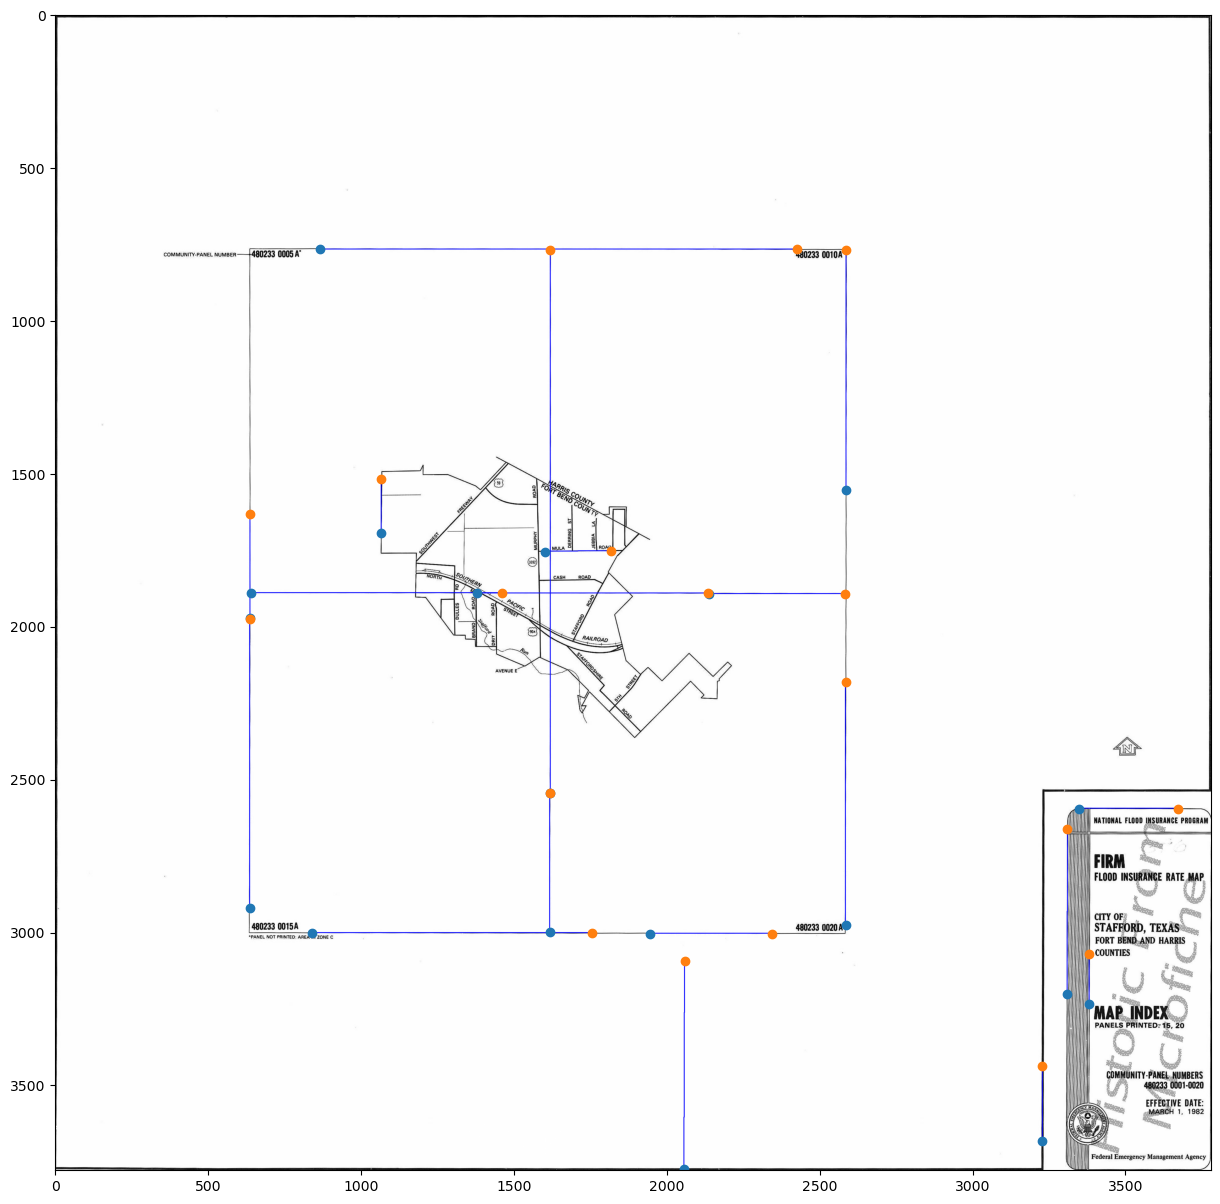

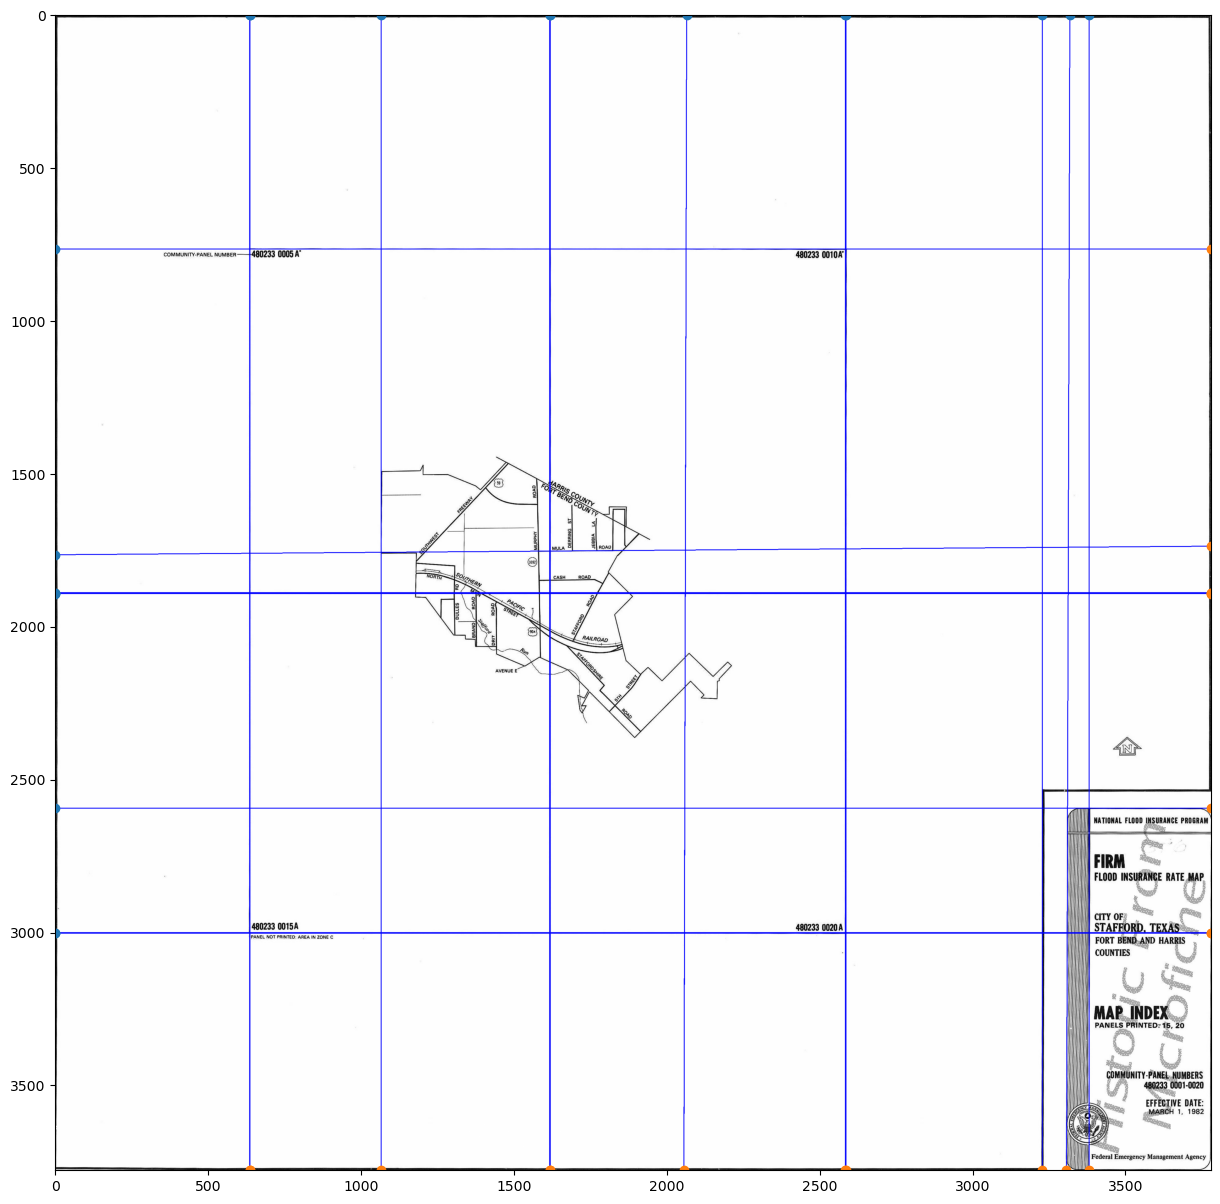

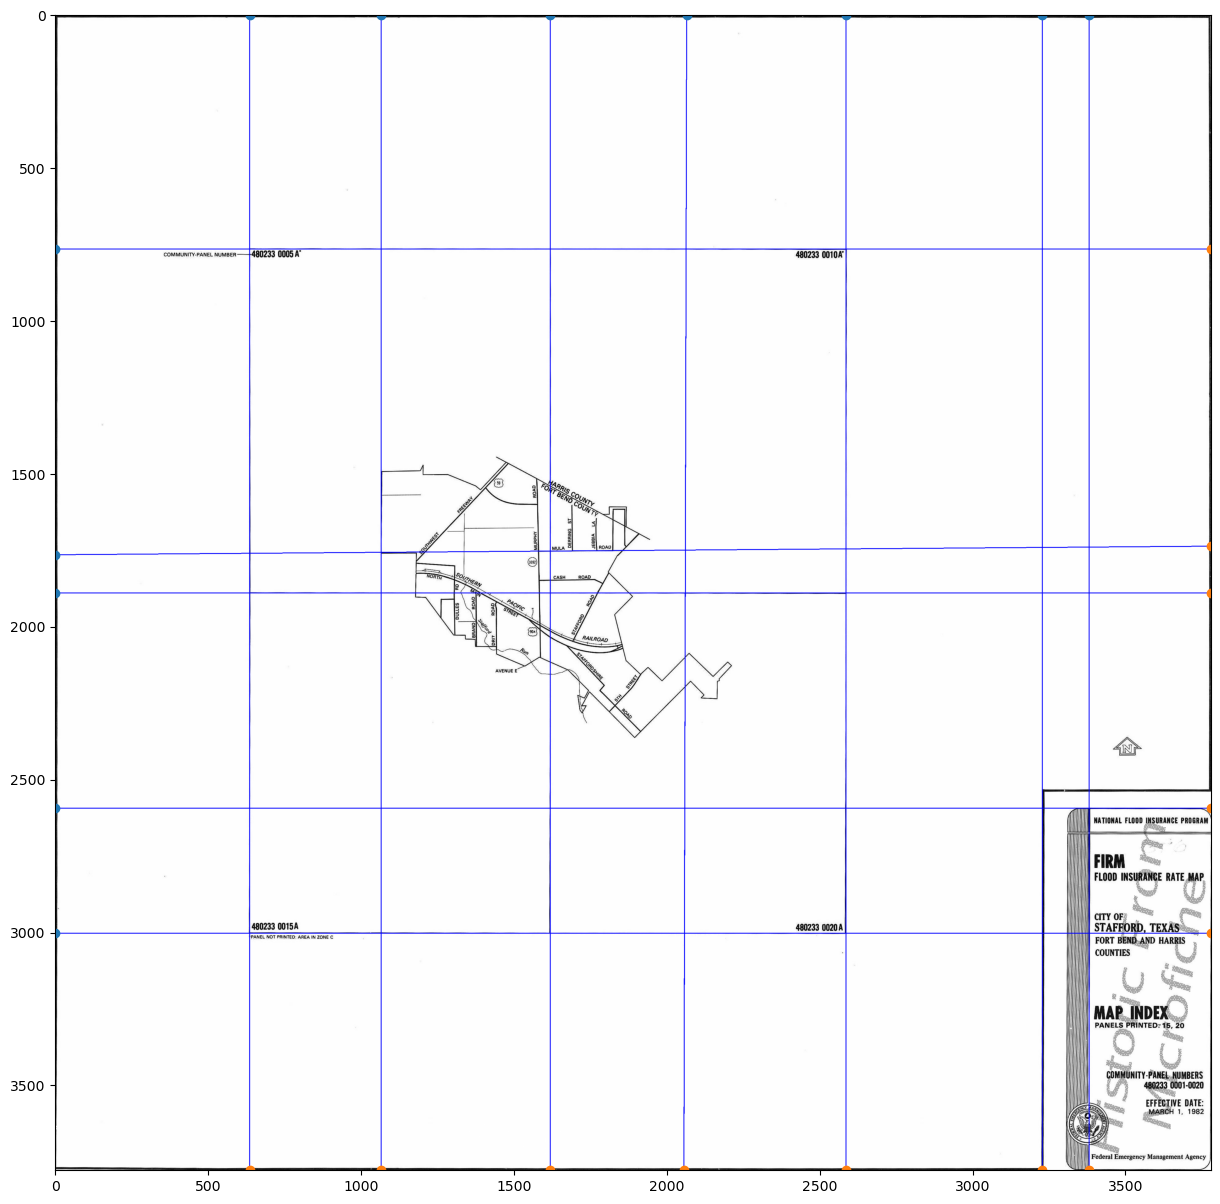

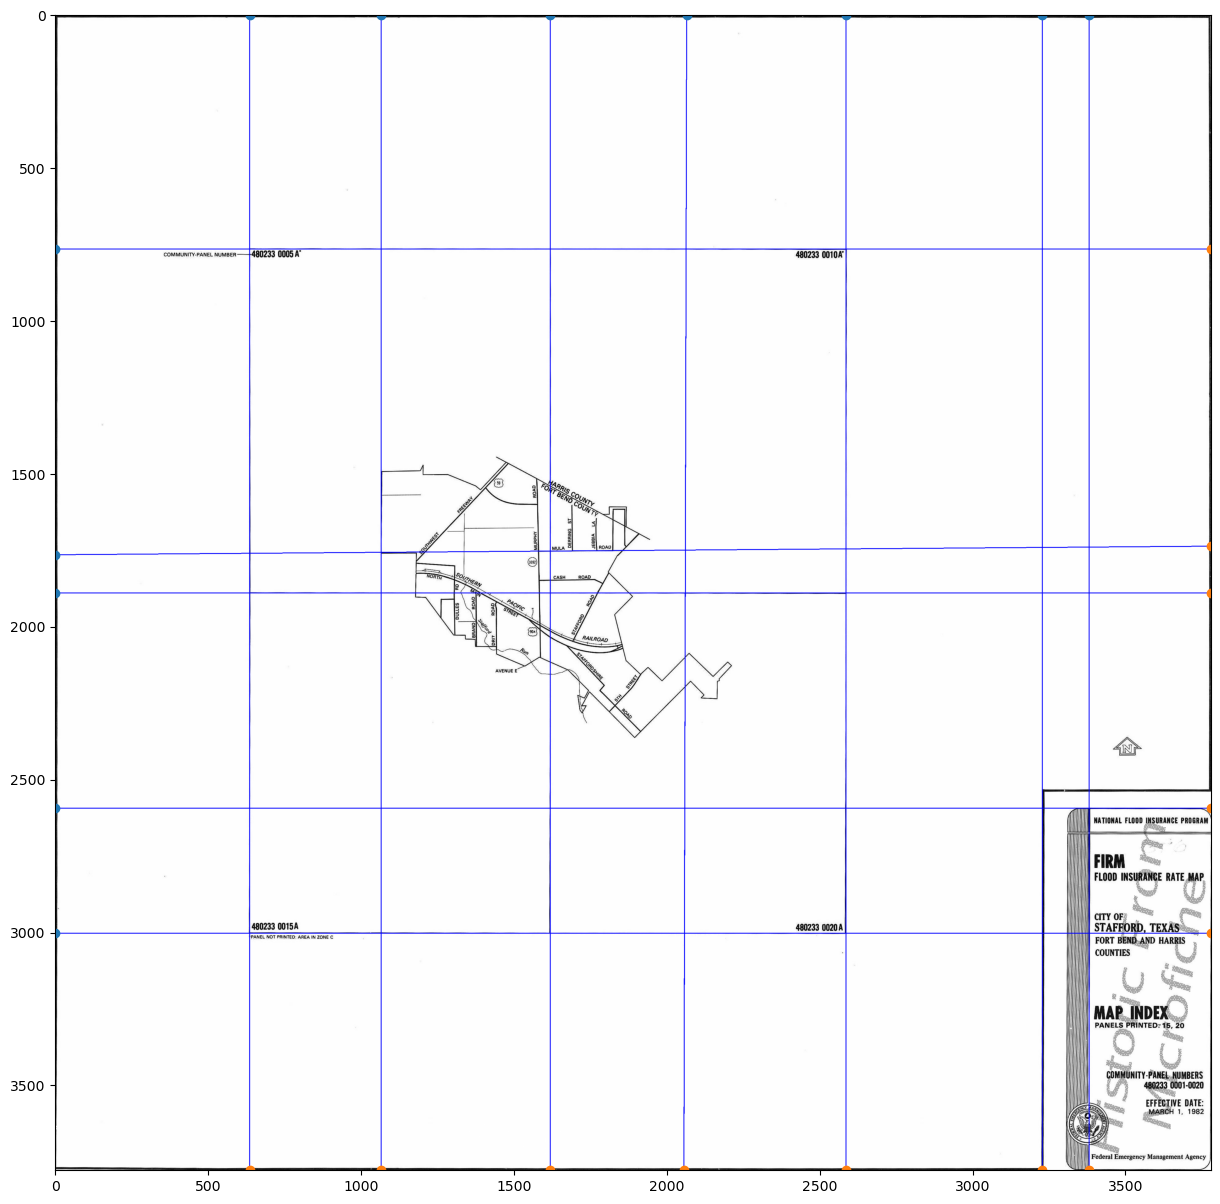

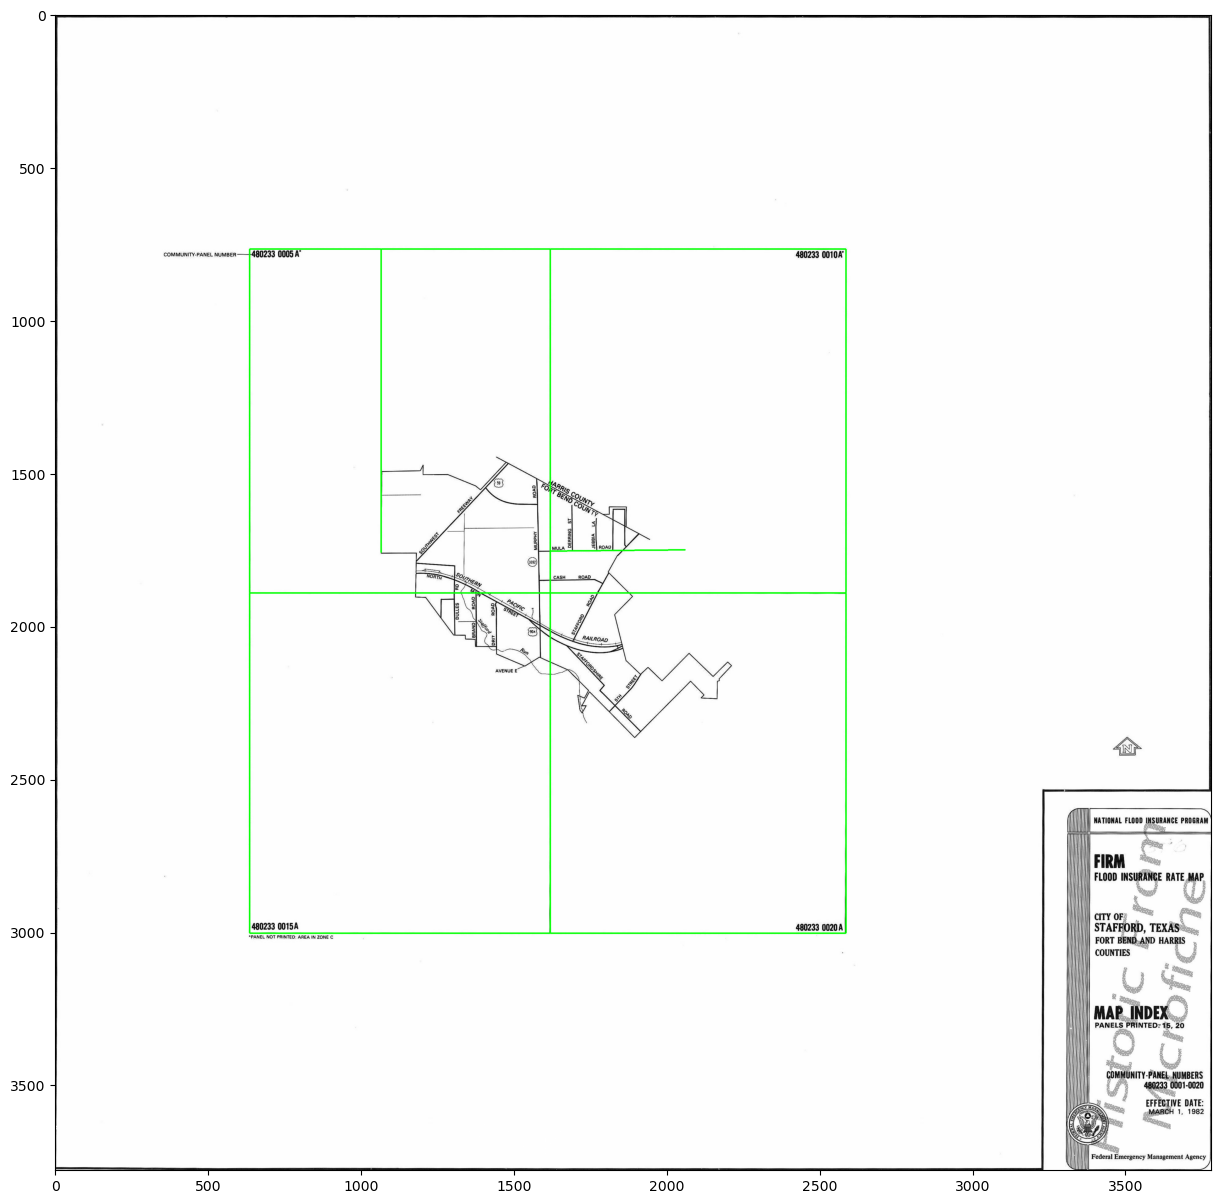

In [12]:
# FIND GRID
out = FindGrid(row["FilePath"])

# PLOT IMAGE
plot_image = np.dstack([image, image, image])
contours = []

# LOOP THROUGH CONTOURS AND ADD THEM TO IMAGE
for k, v in out.items():
    cv2.drawContours(plot_image, v, -1, (0, 255, 0), 3)
    contours.append(contours_to_shapely_polygons(v))
    
plt.imshow(plot_image)
plt.show()

In [13]:
# CALCULATE BOUNDS OF CONTOURS ON IMAGE
bounds_panels = MultiPolygon(contours).bounds
bounds_panels = [int(i) for i in bounds_panels]

# MASK IMAGE
mask = np.zeros(image.shape)
mask[bounds_panels[1]+50:bounds_panels[3]-50, bounds_panels[0]+50:bounds_panels[2]-50] = 1
mask_1 = drawGrid(image)
# mask = # np.logical_or(mask == 1, mask_1)
mask = np.logical_and(~mask_1, mask)

image = 255 - image
image_t = image * mask

In [14]:
def find_bbox(binary_image):
    # Find the coordinates of all "True" elements in the binary image
    nonzero_points = cv2.findNonZero(binary_image)

    if nonzero_points is None:
        return None

    # Calculate the bounding rectangle for the "True" elements
    x, y, w, h = cv2.boundingRect(nonzero_points)

    return x, y, x+w, y+h

bounds_panels_postfilter = find_bbox(np.asarray(cv2.erode(image_t, np.ones((3,3), np.uint8)) > 50).astype(np.uint8))

Assigning Points
Finding Homography
Thin Image


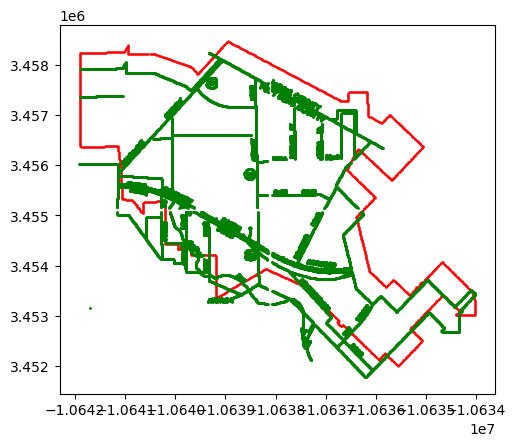

In [15]:
bounds_panels = [i for i in bounds_panels_postfilter]

shp_bounds = largest_polygon.bounds
shp_bounds = [i for i in shp_bounds]

print("Assigning Points")
# BOUNDS AROUND EACH POINT
from_points   = [[bounds_panels[0], bounds_panels[1]], 
               [bounds_panels[0], bounds_panels[3]],
               [bounds_panels[2], bounds_panels[1]],
               [bounds_panels[2], bounds_panels[3]]]

to_points = [[shp_bounds[0], shp_bounds[1]], 
               [shp_bounds[0], shp_bounds[3]],
               [shp_bounds[2], shp_bounds[1]],
               [shp_bounds[2], shp_bounds[3]]]

# TO NUMPY ARRAYS ARRAYS
to_points = np.array(to_points)
from_points = np.array(from_points)

print("Finding Homography")
# GET TRANSFORMS BETWEEN POINTS
output = cv2.findHomography(from_points, to_points, cv2.RANSAC, 1000)

original_homography = output[0]
inverse_transform = np.linalg.inv(original_homography)

print("Thin Image")
# GET THIN IMAGE
thin_image = cv2.ximgproc.thinning(image_t.astype(np.uint8), thinningType=cv2.ximgproc.THINNING_GUOHALL)
y, x = np.where(thin_image[::-1, :])                   # GET COORDINATES OF EVERY 
image_points = np.vstack((x, y, np.ones(x.shape)))     # STACK X, Y, AND Z COORDINATES
outputs = original_homography @ image_points           # TRANSFORM COORDINATES USING ESTIMATES

# PLOT
fig, ax = plt.subplots()
point_boundary_gdf.plot(ax=ax, markersize=0.5, color="r")
ax.scatter(outputs[0, :], outputs[1, :], s=1, color="g")

In [16]:
point_geometry = [[point.geometry.x, point.geometry.y, 1] for i, point in point_boundary_gdf.iterrows()]
point_geometry = inverse_transform @ np.array(point_geometry).T

coords_shp = point_geometry.T[:, :]
coords_ras = np.vstack((image_points[0, :], image_points[1, :], np.ones(image_points[1, :].shape))).T

offsets = np.mean(coords_ras, axis=0)
x_offset = offsets[0]
y_offset = offsets[1]

coords_shp_proc = np.vstack((coords_shp[:, 0] - x_offset, coords_shp[:, 1] - y_offset)).T
coords_ras_proc = np.vstack((coords_ras[:, 0] - x_offset, coords_ras[:, 1] - y_offset)).T

In [17]:
coords_shp_proc.shape

(1624, 2)

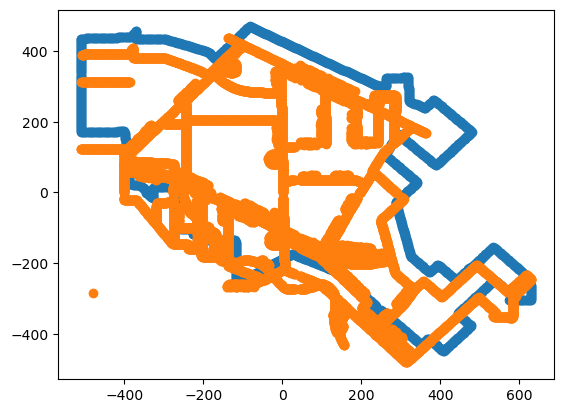

In [18]:
fig, ax = plt.subplots()

ax.scatter(coords_shp_proc[:, 0], coords_shp_proc[:, 1])
ax.scatter(coords_ras_proc[:, 0], coords_ras_proc[:, 1])

  0%|          | 0/100 [00:00<?, ?it/s]

Scale: 0.97 Offset: 6.13
Scale: 1.00 Offset: 1.30
Scale: 1.00 Offset: 0.36
Scale: 1.00 Offset: 0.16
Scale: 1.00 Offset: 0.08
Scale: 1.00 Offset: 0.00
Scale: 1.00 Offset: 0.00
Scale: 1.00 Offset: 0.00
Scale: 1.00 Offset: 0.00
Scale: 1.00 Offset: 0.00


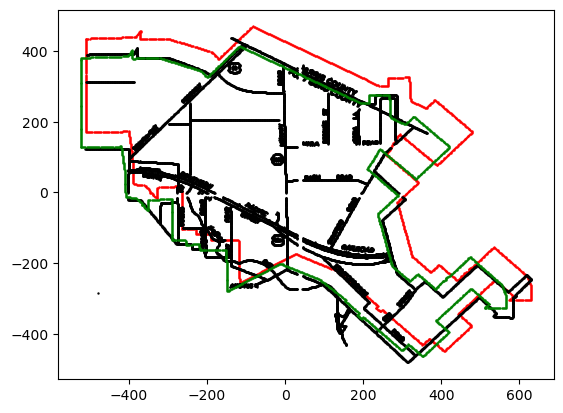

In [91]:
kdtree = cKDTree(coords_ras_proc)

results = []
compounded_homography = np.eye(3)

proc_points = coords_shp_proc
for i in tqdm(range(100)):
    out, new_homography = adjustStep(proc_points, coords_ras_proc, kdtree,
                                    shear=False, rotation=False, perspective=False)
    compounded_homography = compounded_homography @ new_homography
    results.append(out)
    proc_points = out
    
    if i % 10 == 0:
        scale  = np.sqrt((new_homography[0, 0] ** 2 + new_homography[1, 1] ** 2) / 2)
        offset = np.sqrt((new_homography[1, 2] ** 2 + new_homography[0, 2] ** 2) / 2)
        
        print(f"Scale: {scale:.2f} Offset: {offset:.2f}")
        

fig, ax = plt.subplots()

ax.scatter(coords_shp_proc[:, 0], coords_shp_proc[:, 1], c="r", s=0.5)
ax.scatter(coords_ras_proc[:, 0], coords_ras_proc[:, 1], c="black", s=0.5)
ax.scatter(results[-1][:, 0], results[-1][:, 1], c="g", s=0.5)

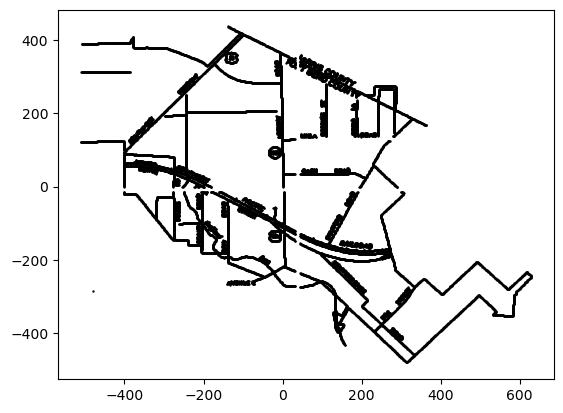

In [27]:
fig, ax = plt.subplots()

ax.scatter(coords_ras_proc[:, 0], coords_ras_proc[:, 1], c="black", s=0.5)

In [20]:
def get_world_file_path(image_path):
    # Get the file extension (e.g., "png", "jpg", "tif")
    file_extension = image_path.split('.')[-1].lower()

    # Define a dictionary to map file extensions to world file extensions
    extension_mapping = {
        'png': 'pgw',
        'jpg': 'jpw',
        'jpeg': 'jpw',  # You can add more extensions if needed
        'tif': 'tfw',
        'tiff': 'tfw',
    }

    # Check if the file extension is in the mapping
    if file_extension in extension_mapping:
        # Replace the file extension with the corresponding world file extension
        world_file_extension = extension_mapping[file_extension]

        # Create the world file path by replacing the image file extension with the world file extension
        world_file_path = os.path.splitext(image_path)[0] + '.' + world_file_extension

        return world_file_path
    else:
        return None  # Unsupported file extension

In [108]:
# REVERSE Y AXIS
rev_y_axis = np.array([[1, 0, 0],
                       [0,-1, 0],
                       [0, 0, 1]])

# move = original_homography @ np.array([0, image_t.shape[0], 0])
translation = np.eye(3)
translation[1, 2] = image_t.shape[0]

adjustment = np.linalg.inv(compounded_homography.copy())
print(adjustment)
adjustment[0, 2] = -1 * adjustment[0, 2]
adjustment[1, 2] = -1 * adjustment[1, 2]
# temp = adjustment[0, 2]
# adjustment[0, 2] = adjustment[1, 2]
# adjustment[1, 2] = temp
print(adjustment)
output_transform = original_homography @ adjustment @ translation @ rev_y_axis 
# output_transform = original_homography @ translation @ rev_y_axis 
#
output_affine = Affine(*output_transform.flatten()[:6])
write_world_file_from_affine(output_affine, get_world_file_path(row["FilePath"]))

[[ 1.04647869  0.         36.8621593 ]
 [ 0.          1.04647869 33.67667539]
 [ 0.          0.          1.        ]]
[[  1.04647869   0.         -36.8621593 ]
 [  0.           1.04647869 -33.67667539]
 [  0.           0.           1.        ]]


In [93]:
original_homography @ translation @ adjustment @ rev_y_axis 

array([[ 6.61114376e+00,  0.00000000e+00, -1.06495602e+07],
       [ 0.00000000e+00, -6.74531035e+00,  3.46823027e+06],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [94]:
adjustment @ original_homography @ translation @ rev_y_axis 

array([[ 6.61114376e+00,  0.00000000e+00, -1.01763691e+07],
       [ 0.00000000e+00, -6.74531035e+00,  3.31437590e+06],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [30]:
adjustment

array([[  0.95558563,   0.        , -35.2249498 ],
       [  0.        ,   0.95558563, -32.18094715],
       [  0.        ,   0.        ,   1.        ]])

In [31]:
original_homography

array([[ 6.91842105e+00,  0.00000000e+00, -1.06493165e+07],
       [ 0.00000000e+00,  7.05882353e+00,  3.44178919e+06],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])